<h1>Importación de librerias</h1>

In [1]:
import os
import pandas as pd
from osgeo import gdal
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib as mpl
import itertools

import xgboost as xgb
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict

<h1>Procesos</h1>

In [2]:
def cargar_datos(path):
    dir = path
    ficheros=[]
    nombre=[]
    
    for file in os.listdir(dir):
        if file.endswith(".tif"):
            ficheros.append(os.path.join(dir, file))
            nombre.append(file.split('.')[0])
            
    sorted(ficheros)
    sorted(nombre)
    
    datos = pd.DataFrame(columns=nombre)
    datos_sin_tocar = pd.DataFrame(columns=nombre)
    datos_para_dibujado = pd.DataFrame(columns=nombre)
    
    tif = gdal.Open(ficheros[1])
    tif_band = tif.GetRasterBand(1)
    x = tif_band.XSize
    y = tif_band.YSize
    
    contador = 0
    for f in ficheros:
        n = nombre[contador]
        MDT = gdal.Open(f)

        # Patrones sin datos se incluyen como -1
        MDT.GetRasterBand(1).SetNoDataValue(-1)

        # Pasamos los datos a float
        band = MDT.GetRasterBand(1).ReadAsArray().astype(float)

        # Se desechan las dos primeras filas y columnas debido a calculos de borde
        band = band[1:y, 1:x]

        # Reconstruimos el array con el tamaño de filas x columnas
        x_recorte = x - 1
        y_recorte = y - 1
        band = np.reshape(band, x_recorte*y_recorte)

        # Estos serán nuestros datos
        datos[n] = band
        datos_sin_tocar[n] = band
        datos_para_dibujado[n] = band

        contador = contador + 1
    
    return datos, datos_para_dibujado, datos_sin_tocar, x, y

In [3]:
def tratamiento_datos_Berrueco(datos):
    # Eliminación de datos erroneos por la importación de datos

    datos = datos[datos['Carcavas'] != -9999]
    datos = datos[datos['Orientaciones'] != 0]
    datos = datos[datos['Distancia_Carreteras'] >= 0]
    datos = datos[datos['Factor_LS'] >= 0]
    datos = datos[datos['Pendiente'] != -9999.0]

    # Eliminación de variables poco utilizadas por el modelo
    datos = datos.drop(columns=['Factor_LS'])
    datos = datos.drop(columns=['Carbonatos'])
    datos = datos.drop(columns=['Geologia'])
    datos = datos.drop(columns=['Usos_Del_Suelo'])
    datos = datos.drop(columns=['Unidades_Edaficas'])

    # Creación de manera eficiente los datos categóricos (float -> string)

    # Orientaciones
    datos.loc[datos.Orientaciones == 1, "Orientaciones"] = "Norte"
    datos.loc[datos.Orientaciones == 2, "Orientaciones"] = "Noreste"
    datos.loc[datos.Orientaciones == 3, "Orientaciones"] = "Este"
    datos.loc[datos.Orientaciones == 4, "Orientaciones"] = "Sureste"
    datos.loc[datos.Orientaciones == 5, "Orientaciones"] = "Sur"
    datos.loc[datos.Orientaciones == 6, "Orientaciones"] = "Suroeste"
    datos.loc[datos.Orientaciones == 7, "Orientaciones"] = "Oeste"
    datos.loc[datos.Orientaciones == 8, "Orientaciones"] = "Noroeste"
    
    datos = datos.round(2)
    
    datos["Orientaciones"] = datos["Orientaciones"].astype("category")
    
    categorical_cols = ['Orientaciones']

    le = LabelEncoder()
    ohe = OneHotEncoder()

    datos[categorical_cols] = datos[categorical_cols].apply(lambda col: le.fit_transform(col))  
    
    return datos

In [4]:
def tratamiento_datos_SantoTome(datos):
    
    datos = datos[datos['Carcavas'] != -9999]
    datos = datos[datos['Orientaciones'] != 0]
    datos = datos[datos['Distancia_Carreteras'] >= 0]
    datos = datos[datos['Pendiente'] != -9999.0]
    datos = datos[datos['Unidades_Edaficas'] != -9999.0]

    # Eliminación de variables poco utilizadas por el modelo
    datos = datos.drop(columns=['Factor_LS'])
    datos = datos.drop(columns=['Carbonatos'])
    datos = datos.drop(columns=['Geologia'])
    datos = datos.drop(columns=['Usos_Del_Suelo'])
    datos = datos.drop(columns=['Unidades_Edaficas'])

    # Orientaciones
    datos.loc[datos.Orientaciones == 8, "Orientaciones"] = "Noroeste"
    datos.loc[datos.Orientaciones == 7, "Orientaciones"] = "Oeste"
    datos.loc[datos.Orientaciones == 5, "Orientaciones"] = "Sur"
    datos.loc[datos.Orientaciones == 6, "Orientaciones"] = "Suroeste"
    datos.loc[datos.Orientaciones == 1, "Orientaciones"] = "Norte"
    datos.loc[datos.Orientaciones == 4, "Orientaciones"] = "Sureste"
    datos.loc[datos.Orientaciones == 2, "Orientaciones"] = "Noreste"
    datos.loc[datos.Orientaciones == 3, "Orientaciones"] = "Este"
    
    datos = datos.round(2)
    
    datos["Orientaciones"] = datos["Orientaciones"].astype("category")
    
    categorical_cols = ['Orientaciones']

    le = LabelEncoder()
    ohe = OneHotEncoder()

    datos[categorical_cols] = datos[categorical_cols].apply(lambda col: le.fit_transform(col))  
    
    return datos

In [5]:
def tratamiento_datos_sin_tocar_Berrueco(datos_sin_tocar):
    # Geología
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 9001, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 9004, "Geologia"] = "Arenas_fondo"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 9103, "Geologia"] = "Calizas_dolomias"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 9132, "Geologia"] = "Calcarenitas"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 9133, "Geologia"] = "Margas"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 9134, "Geologia"] = "Areniscas"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 9201, "Geologia"] = "Unidades_guadalquivir"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 9202, "Geologia"] = "Calizas_margosas"

    # Unidades edáficas
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 1, "Unidades_Edaficas"] = "Vertisoles_CCV"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 2, "Unidades_Edaficas"] = "Cambisoles_VVCCC"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 3, "Unidades_Edaficas"] = "Regosoles_CLCC"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 4, "Unidades_Edaficas"] = "Cambisoles_VRCVC"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 5, "Unidades_Edaficas"] = "Vertisoles_P"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 6, "Unidades_Edaficas"] = "Regosoles_CC"

    # Usos del suelo
    datos_sin_tocar.loc[datos_sin_tocar.Usos_Del_Suelo == 1, "Usos_Del_Suelo"] = "Tejido_urbano"
    datos_sin_tocar.loc[datos_sin_tocar.Usos_Del_Suelo == 2, "Usos_Del_Suelo"] = "Olivares"
    datos_sin_tocar.loc[datos_sin_tocar.Usos_Del_Suelo == 3, "Usos_Del_Suelo"] = "Cultivos_permanentes"
    datos_sin_tocar.loc[datos_sin_tocar.Usos_Del_Suelo == 4, "Usos_Del_Suelo"] = "Pastizales"

    # Orientaciones
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 1, "Orientaciones"] = "Norte"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 2, "Orientaciones"] = "Noreste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 3, "Orientaciones"] = "Este"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 4, "Orientaciones"] = "Sureste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 5, "Orientaciones"] = "Sur"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 6, "Orientaciones"] = "Suroeste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 7, "Orientaciones"] = "Oeste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 8, "Orientaciones"] = "Noroeste"

    # Cambios para la visualización, no van a tener efecto en la predicción, puesto que luego serán
    # modificados todos aquellos valores fuera del límite geográfico.
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Unidades_Edaficas"] = "Vertisoles_CCV"
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Usos_Del_Suelo"] = "Tejido_urbano"
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Orientaciones"] = "Norte"
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Carcavas"] = 0

    datos_sin_tocar.loc[datos_sin_tocar.Distancia_Carreteras < 0, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Distancia_Carreteras < 0, "Unidades_Edaficas"] = "Vertisoles_CCV"
    datos_sin_tocar.loc[datos_sin_tocar.Distancia_Carreteras < 0, "Usos_Del_Suelo"] = "Tejido_urbano"
    datos_sin_tocar.loc[datos_sin_tocar.Distancia_Carreteras < 0, "Orientaciones"] = "Norte"

    datos_sin_tocar.loc[datos_sin_tocar.Factor_LS < 0, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Factor_LS < 0, "Unidades_Edaficas"] = "Vertisoles_CCV"
    datos_sin_tocar.loc[datos_sin_tocar.Factor_LS < 0, "Usos_Del_Suelo"] = "Tejido_urbano"
    datos_sin_tocar.loc[datos_sin_tocar.Factor_LS < 0, "Orientaciones"] = "Norte"

    datos_sin_tocar.loc[datos_sin_tocar.Pendiente == -9999.0, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Pendiente == -9999.0, "Unidades_Edaficas"] = "Vertisoles_CCV"
    datos_sin_tocar.loc[datos_sin_tocar.Pendiente == -9999.0, "Usos_Del_Suelo"] = "Tejido_urbano"
    datos_sin_tocar.loc[datos_sin_tocar.Pendiente == -9999.0, "Orientaciones"] = "Norte"

    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 0, "Orientaciones"] = "Norte"

    datos_sin_tocar = datos_sin_tocar.drop(columns=['Factor_LS'])
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Carbonatos'])
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Geologia'])
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Usos_Del_Suelo'])
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Unidades_Edaficas'])
    
    return datos_sin_tocar

In [6]:
def tratamiento_datos_sin_tocar_SantoTome(datos_sin_tocar):
    # Geología
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 1, "Geologia"] = "Calizas"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 2, "Geologia"] = "Arenas"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 3, "Geologia"] = "Calcarenitas"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 4, "Geologia"] = "Margas"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 5, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Geologia == 6, "Geologia"] = "Brechas"

    # Unidades edáficas
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 48, "Unidades_Edaficas"] = "Cambisoles_RV"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 44, "Unidades_Edaficas"] = "Cambisoles_RLR"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 22, "Unidades_Edaficas"] = "Vertisoles_PC"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == 23, "Unidades_Edaficas"] = "Vertisoles_CCRV"

    # Usos del suelo
    datos_sin_tocar.loc[datos_sin_tocar.Usos_Del_Suelo == 3, "Usos_Del_Suelo"] = "Olivares"
    datos_sin_tocar.loc[datos_sin_tocar.Usos_Del_Suelo == 2, "Usos_Del_Suelo"] = "Labor_secano"
    datos_sin_tocar.loc[datos_sin_tocar.Usos_Del_Suelo == 4, "Usos_Del_Suelo"] = "Mosaico_cultivos"

    # Orientaciones
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 8, "Orientaciones"] = "Noroeste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 7, "Orientaciones"] = "Oeste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 5, "Orientaciones"] = "Sur"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 6, "Orientaciones"] = "Suroeste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 1, "Orientaciones"] = "Norte"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 4, "Orientaciones"] = "Sureste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 2, "Orientaciones"] = "Noreste"
    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 3, "Orientaciones"] = "Este"

    # Cambios para la visualización, no van a tener efecto en la predicción, puesto que luego serán
    # modificados todos aquellos valores fuera del límite geográfico.
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Unidades_Edaficas"] = "Cambisoles_RV"
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Usos_Del_Suelo"] = "Mosaico_cultivos"
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Orientaciones"] = "Norte"
    datos_sin_tocar.loc[datos_sin_tocar.Carcavas == -9999, "Carcavas"] = 0

    datos_sin_tocar.loc[datos_sin_tocar.Distancia_Carreteras < 0, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Distancia_Carreteras < 0, "Unidades_Edaficas"] = "Cambisoles_RV"
    datos_sin_tocar.loc[datos_sin_tocar.Distancia_Carreteras < 0, "Usos_Del_Suelo"] = "Mosaico_cultivos"
    datos_sin_tocar.loc[datos_sin_tocar.Distancia_Carreteras < 0, "Orientaciones"] = "Norte"

    datos_sin_tocar.loc[datos_sin_tocar.Factor_LS < 0, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Factor_LS < 0, "Unidades_Edaficas"] = "Cambisoles_RV"
    datos_sin_tocar.loc[datos_sin_tocar.Factor_LS < 0, "Usos_Del_Suelo"] = "Mosaico_cultivos"
    datos_sin_tocar.loc[datos_sin_tocar.Factor_LS < 0, "Orientaciones"] = "Norte"

    datos_sin_tocar.loc[datos_sin_tocar.Pendiente == -9999.0, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Pendiente == -9999.0, "Unidades_Edaficas"] = "Cambisoles_RV"
    datos_sin_tocar.loc[datos_sin_tocar.Pendiente == -9999.0, "Usos_Del_Suelo"] = "Mosaico_cultivos"
    datos_sin_tocar.loc[datos_sin_tocar.Pendiente == -9999.0, "Orientaciones"] = "Norte"

    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == -9999.0, "Geologia"] = "Conglomerados"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == -9999.0, "Unidades_Edaficas"] = "Cambisoles_RV"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == -9999.0, "Usos_Del_Suelo"] = "Mosaico_cultivos"
    datos_sin_tocar.loc[datos_sin_tocar.Unidades_Edaficas == -9999.0, "Orientaciones"] = "Norte"

    datos_sin_tocar.loc[datos_sin_tocar.Orientaciones == 0, "Orientaciones"] = "Norte"
    
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Factor_LS'])
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Carbonatos'])
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Geologia'])
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Usos_Del_Suelo'])
    datos_sin_tocar = datos_sin_tocar.drop(columns=['Unidades_Edaficas'])
    
    return datos_sin_tocar

In [7]:
def modelo_XGBoost(learning_rate, depth, estimators):
    modelo_xgb = xgb.XGBClassifier(use_label_encoder=False, verbosity=0, eta=learning_rate,
                                max_depth=depth, sampling_method='gradient_based',
                                objetive='binary:logitraw', scale_pos_weight=0.97,
                                n_estimators=estimators)
    return modelo_xgb

In [8]:
def m_confusion(Y_test, Y_pred):
    cnf_matrix = confusion_matrix(Y_test, Y_pred, labels=[1,0])
    tp, fn, fp, tn = cnf_matrix.ravel()
    return tp, fn, fp, tn

In [9]:
def kappa(TP, FP, FN, TN):
    N = TP+TN+FP+FN

    precision = (TP+TN)/(TP+TN+FP+FN)
    
    Pexp = ((TP+FN)*(TP+FP)+(FP+TN)*(FN+TN))/(N*N)
    
    Pobs = (TP+TN)/N
    
    k = (Pobs - Pexp)/(1 - Pexp)
    
    return k

In [10]:
def prediccion_cruzada(modelo, x, y, particiones):  
    y_pred = cross_val_predict(modelo, x, y, cv=particiones)
    return y_pred

In [11]:
def validaciones(modelo):
    
    y_pred = modelo_xgb.predict(x)
    tp, fn, fp, tn = m_confusion(y, y_pred)
    k = kappa(tp, fp, fn, tn)

    return k, tp

In [12]:
def validaciones_modelo2(modelo, x_pred, y_P):
    
    y_pred = modelo_xgb.predict(x_pred)
    tp, fn, fp, tn = m_confusion(y_P, y_pred)
    k = kappa(tp, fp, fn, tn)

    return k, tp

In [13]:
def dibujar_inline(prediccion, x, y):
    SalidaDibujo = np.reshape(prediccion, (y,x))
    print(SalidaDibujo.shape)
    
    #configuracion necesaria de pyplot para ver las imagenes en escala de grises  
    plt.rcParams['image.cmap'] = 'jet'
    plt.figure(figsize=(14,14))
    plt.imshow(SalidaDibujo, vmin=0, vmax=1)
    return SalidaDibujo

In [14]:
def dibujar_inline_X(prediccion, x, y):

    cmap = mpl.colors.ListedColormap(['green','limegreen','yellow','orange','darkgoldenrod','red','black'])
    bins = [0.0, 0.05, 0.2, 0.4, 0.7, 0.8, 1.0]

    norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors)-1 )

    SalidaDibujo = np.reshape(prediccion, (y,x))
    
    x = np.arange(0, x, 1)
    y = np.arange(0, y, 1)
    
    fig, ax = plt.subplots(figsize=(14,14))
    ax.pcolormesh(x, y, SalidaDibujo, cmap = cmap, norm=norm, shading='flat')

    fig.show()
    return SalidaDibujo

In [15]:
def dibujarCustomBar():
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    cmap = mpl.colors.ListedColormap(['green','limegreen','yellow','orange','darkgoldenrod','red','black'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    bounds = [0.0, 0.05, 0.2, 0.4, 0.7, 0.8, 1.0]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    boundaries=[0] + bounds + [13],
                                    extend='both',
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='horizontal')
    fig.show()

<h1>Modelo 1. Entrenamiento total - PRINCIPAL</h1>

In [16]:
# Carga de datos y tratamiento Santo Tomé
"""
path = "Raster/SantoTome"
datos = cargar_datos(path)
datos = tratamiento_datos_SantoTome(datos)
y = datos.Carcavas
datos = datos.drop(['Carcavas'], axis=1)
x = datos

# Entrenamiento
print("Entrenando modelo")
modelo_xgb = modelo_XGBoost(0.1, 6, 150)
modelo_xgb.fit(x, y)

# Carga de datos y tratamiento Berrueco
path = "Raster/Berrueco II"
datos = cargar_datos(path)
datos = tratamiento_datos_Berrueco(datos)
y = datos.Carcavas
datos = datos.drop(['Carcavas'], axis=1)
x = datos

# Validaciones
print("Validando modelo")
k, tp = validaciones(modelo_xgb, )
print("K: ", k)
print("TP: ", tp)
"""

'\npath = "Raster/SantoTome"\ndatos = cargar_datos(path)\ndatos = tratamiento_datos_SantoTome(datos)\ny = datos.Carcavas\ndatos = datos.drop([\'Carcavas\'], axis=1)\nx = datos\n\n# Entrenamiento\nprint("Entrenando modelo")\nmodelo_xgb = modelo_XGBoost(0.1, 6, 150)\nmodelo_xgb.fit(x, y)\n\n# Carga de datos y tratamiento Berrueco\npath = "Raster/Berrueco II"\ndatos = cargar_datos(path)\ndatos = tratamiento_datos_Berrueco(datos)\ny = datos.Carcavas\ndatos = datos.drop([\'Carcavas\'], axis=1)\nx = datos\n\n# Validaciones\nprint("Validando modelo")\nk, tp = validaciones(modelo_xgb, )\nprint("K: ", k)\nprint("TP: ", tp)\n'

<h1>Modelo 2. Entrenamiento parcial de ambas - PRINCIPAL</h1>

In [17]:
# Carga de datos y tratamiento Santo Tomé
path = "Raster/SantoTome"
datos, datos_para_dibujado_3, datos_sin_tocar, x_siz, y_siz = cargar_datos(path)
datos = tratamiento_datos_SantoTome(datos)

datos_mitad = np.array_split(datos, 2)

# Carga de datos y tratamiento Berrueco
path = "Raster/Berrueco II"
datos2, datos_para_dibujado_2, datos_sin_tocar, x_siz, y_siz = cargar_datos(path)
datos2 = tratamiento_datos_Berrueco(datos2)

datos_mitad2 = np.array_split(datos2, 2)

# Unión de datos
print("Uniendo datos")
frames = [datos_mitad[0], datos_mitad2[0]]
datos = pd.concat(frames)
y = datos.Carcavas
datos = datos.drop(['Carcavas'], axis=1)
x = datos

# Entrenamiento con 0.1 learning rate, 6 de máxima profundidad y 150 estimadores
print("Entrenando modelo")
modelo_xgb = modelo_XGBoost(0.05, 4, 60)
modelo_xgb.fit(x, y)



# ----------------------------------------------------------------------------- #
# ----------------------------------------------------------------------------- #
# ----------------------------------------------------------------------------- #


# Validación

path = "Raster/Berrueco II"
#path = "Raster/SantoTome"

datos, datos_para_dibujado, datos_sin_tocar, x_siz, y_siz = cargar_datos(path)
print("Datos para el dibujado ", len(datos_para_dibujado))

datos = tratamiento_datos_Berrueco(datos)
#datos = tratamiento_datos_SantoTome(datos)

y = datos.Carcavas
datos = datos.drop(['Carcavas'], axis=1)
x = datos

# Validaciones
print("Validando modelo")
k, tp = validaciones_modelo2(modelo_xgb, x, y)
print("K: ", k)
print("TP: ", tp)

Uniendo datos
Entrenando modelo
Datos para el dibujado  1506681
Validando modelo
K:  0.12321254699657132
TP:  1858


<h1>Preparacion de mapa de susceptibilidad</h1>

In [18]:
# Preparando la variable X

path = "Raster/Berrueco II"
#path = "Raster/SantoTome"

datos, datos_para_dibujado, datos_sin_tocar, x_siz, y_siz = cargar_datos(path)

datos_sin_tocar = tratamiento_datos_sin_tocar_Berrueco(datos_sin_tocar)
#datos_sin_tocar = tratamiento_datos_sin_tocar_SantoTome(datos_sin_tocar)

Y = datos_sin_tocar.Carcavas
datos_sin_tocar = datos_sin_tocar.drop(['Carcavas'], axis=1)
X = datos_sin_tocar

X["Orientaciones"] = X["Orientaciones"].astype("category")

X = X.round(2)

categorical_cols = ['Orientaciones']

le = LabelEncoder()
ohe = OneHotEncoder()

X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))  

print(len(X))

1506681


In [19]:
# Dibujar el mapa de susceptibilidad
prob_pre = modelo_xgb.predict_proba(X)

total = (prob_pre.size / 2)
array_color = [0] * int(total)

for i in range(int(total)):
    array_color[i] = prob_pre[i][1]

for i in datos_para_dibujado.index:
    if datos_para_dibujado["Carcavas"][i] == -9999 or datos_para_dibujado["Orientaciones"][i] == 0 or datos_para_dibujado["Distancia_Carreteras"][i] < 0 or datos_para_dibujado["Factor_LS"][i] < 0 or datos_para_dibujado["Pendiente"][i] == -9999 or datos_para_dibujado["Unidades_Edaficas"][i] == -9999 :
        array_color[i] = 0


C:\Users\bulth\AppData\Local\Temp/ipykernel_6204/576432424.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(x, y, SalidaDibujo, cmap = cmap, norm=norm, shading='flat')
C:\Users\bulth\AppData\Local\Temp/ipykernel_6204/576432424.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


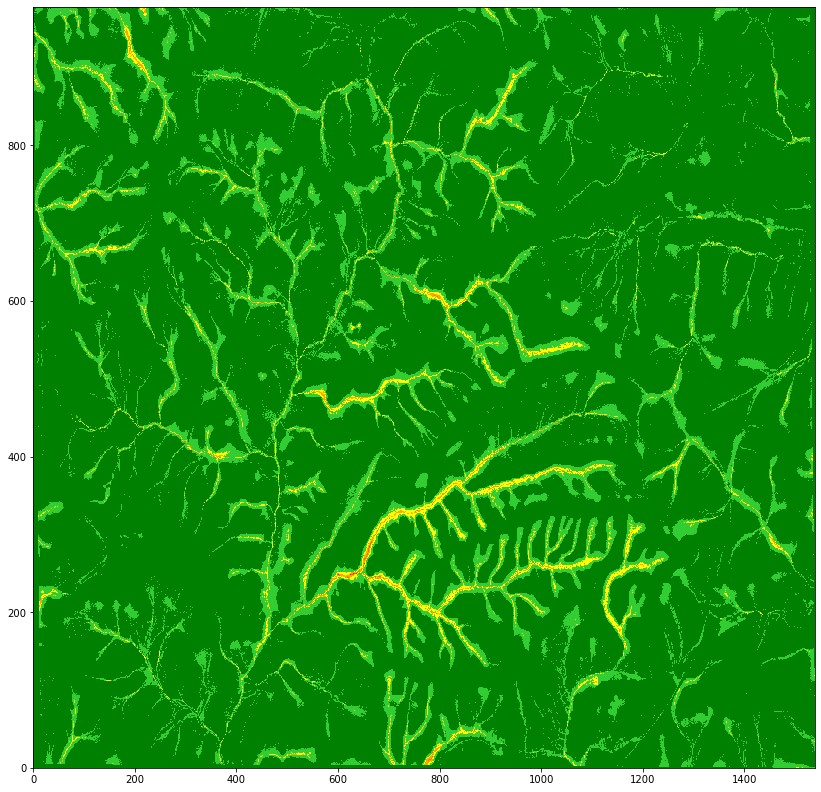

In [20]:
SalidaDibujo = dibujar_inline_X(array_color, x_siz-1, y_siz-1)

<h1>Salida para transformacion en R</h1>

In [21]:
array_zero = np.zeros(SalidaDibujo.shape[1])
array_zero = array_zero + 1
salida = np.vstack((array_zero, SalidaDibujo))

array_zero_2 = np.zeros(salida.shape[0])
salida = np.hstack((array_zero_2.reshape(len(array_zero_2), 1), salida))

#pd.DataFrame(salida).to_csv('prediccion_ST.csv', index = False, header = False)
pd.DataFrame(salida).to_csv('prediccion_BR.csv', index = False, header = False)

C:\Users\bulth\AppData\Local\Temp/ipykernel_6204/3036282315.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


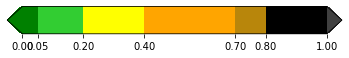

In [22]:
dibujarCustomBar()